## Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sentencepiece as spm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

import re
import os
import random
import math

from gensim.models import Word2Vec
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from konlpy.tag import Mecab
from tensorflow import keras
from tqdm import tqdm_notebook

In [2]:
#!pip install --upgrade gensim==3.8.3

## Data load

In [3]:
path = os.getenv('HOME')+'/aiffel/transformer_chatbot/data'

In [4]:
data = pd.read_csv(path +'/ChatbotData.csv')
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


## EDA

In [5]:
len(data)

11823

In [6]:
data.isnull().sum()

Q        0
A        0
label    0
dtype: int64

In [7]:
data = data.iloc[:,:2]
data.head()

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.


In [8]:
for i in range(10):
    print('Q :', data['Q'][i])
    print('A :', data['A'][i])    
    print()

Q : 12시 땡!
A : 하루가 또 가네요.

Q : 1지망 학교 떨어졌어
A : 위로해 드립니다.

Q : 3박4일 놀러가고 싶다
A : 여행은 언제나 좋죠.

Q : 3박4일 정도 놀러가고 싶다
A : 여행은 언제나 좋죠.

Q : PPL 심하네
A : 눈살이 찌푸려지죠.

Q : SD카드 망가졌어
A : 다시 새로 사는 게 마음 편해요.

Q : SD카드 안돼
A : 다시 새로 사는 게 마음 편해요.

Q : SNS 맞팔 왜 안하지ㅠㅠ
A : 잘 모르고 있을 수도 있어요.

Q : SNS 시간낭비인 거 아는데 매일 하는 중
A : 시간을 정하고 해보세요.

Q : SNS 시간낭비인데 자꾸 보게됨
A : 시간을 정하고 해보세요.



In [9]:
data[data.duplicated(['Q'])]

,Q,A
196,고양이 키우고 싶어,가족들과 상의해보세요.
235,공시 준비 힘들어,잘 될 거예요.
1294,돈 벌고 싶어,많이 벌수록 좋아요.
1445,로또 번호 알려줘,알면 제가 하죠.
1481,마음이 울적해,거리를 걸어보세요.
...,...,...
11642,착해서 잘해주는 건지 좋아하는 건지,헷갈린다고 말해보세요.
11649,첫 눈에 반하는게 가능해?,당연히 가능하죠.
11658,첫사랑 생각나,지금의 사랑에 충실하세요.
11732,커플여행이 나을까 그냥 우리끼리 갈까?,저는 둘이 가는 게 좋아요.


In [10]:
data[data.duplicated(['A'])]

,Q,A
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.
12,가끔 뭐하는지 궁금해,그 사람도 그럴 거예요.
18,가스불 켜놓고 나온거 같아,빨리 집에 돌아가서 끄고 나오세요.
...,...,...
11806,혼자만 설레고 혼자서 끝내는 짝사랑 그만할래.,맘고생 많았어요.
11807,화이트데이에 고백할까요?,선물을 주면서 솔직하고 당당하게 고백해보세요.
11809,확실히 날 좋아하는 걸 아는 남자랑 친구가 될 수 있을까?,그 사람을 위해서는 그러면 안돼요.
11816,회식하는데 나만 챙겨줘. 썸임?,호감이 있을 수도 있어요. 그렇지만 조금 더 상황을 지켜보세요.


문장의 최단 길이: 1
문장의 최장 길이: 56
문장의 평균 길이: 12


/tmp/ipykernel_375/1381028093.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_length = np.zeros((max_len), dtype=np.int)


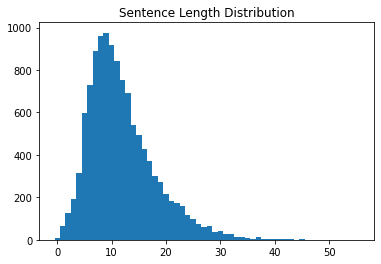

In [11]:
min_len = 999
max_len = 0
sum_len = 0

for sen in data['Q']:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(data['Q']))

train_length = np.zeros((max_len), dtype=np.int)

for sen in data['Q']:   # 중복이 제거된 코퍼스 기준
    train_length[len(sen)-1] += 1

plt.bar(range(max_len), train_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

문장의 최단 길이: 1
문장의 최장 길이: 76
문장의 평균 길이: 15


/tmp/ipykernel_375/2128007342.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_length = np.zeros((max_len), dtype=np.int)


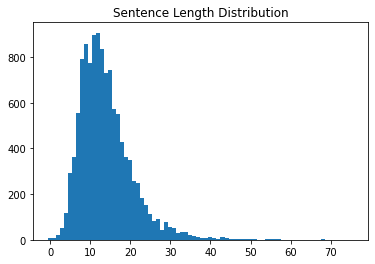

In [12]:
min_len = 999
max_len = 0
sum_len = 0

for sen in data['A']:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(data['A']))

train_length = np.zeros((max_len), dtype=np.int)

for sen in data['A']:   # 중복이 제거된 코퍼스 기준
    train_length[len(sen)-1] += 1

plt.bar(range(max_len), train_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

## Preprocessing and Tokeninzing

In [13]:
def preprocess_sentence(sentence):
    
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ0-9]+", " ", sentence)
    sentence = sentence.strip()
    
    return sentence

In [14]:
temp = []
max = 0
for i in data['A']:
    length = len(preprocess_sentence(i))
    if max_len < length: max_len = length
    temp.append(preprocess_sentence(i))
    
print(max_len)

76


In [15]:
def build_corpus(row_file):
    que_corpus = []
    ans_corpus = []
    
    for i in range(0, len(row_file)):
        mecab = Mecab()
        
        que, ans = row_file.loc[i]
        
        que = preprocess_sentence(que)
        que = mecab.morphs(que)
        
        ans = preprocess_sentence(ans)
        ans = mecab.morphs(ans)
        
        if len(que) < 20 and len(ans) < 20 : # 길이의 75퍼센타일 
            if que not in que_corpus:
                if ans not in ans_corpus: #소스와 타겟별 중복 검사
                    que_corpus.append(que)
                    ans_corpus.append(ans)
    
    return que_corpus, ans_corpus

In [16]:
que_corpus, ans_corpus = build_corpus(data)

In [17]:
que_corpus[:10]

[['12', '시', '땡', '!'],
 ['1', '지망', '학교', '떨어졌', '어'],
 ['3', '박', '4', '일', '놀', '러', '가', '고', '싶', '다'],
 ['ppl', '심하', '네'],
 ['sd', '카드', '망가졌', '어'],
 ['sns', '맞', '팔', '왜', '안', '하', '지', 'ㅠㅠ'],
 ['sns', '시간', '낭비', '인', '거', '아', '는데', '매일', '하', '는', '중'],
 ['sns', '보', '면', '나', '만', '빼', '고', '다', '행복', '해', '보여'],
 ['가끔', '궁금', '해'],
 ['가끔', '은', '혼자', '인', '게', '좋', '다']]

In [18]:
ans_corpus[:10]

[['하루', '가', '또', '가', '네요', '.'],
 ['위로', '해', '드립니다', '.'],
 ['여행', '은', '언제나', '좋', '죠', '.'],
 ['눈살', '이', '찌푸려', '지', '죠', '.'],
 ['다시', '새로', '사', '는', '게', '마음', '편해요', '.'],
 ['잘', '모르', '고', '있', '을', '수', '도', '있', '어요', '.'],
 ['시간', '을', '정하', '고', '해', '보', '세요', '.'],
 ['자랑', '하', '는', '자리', '니까요', '.'],
 ['그', '사람', '도', '그럴', '거', '예요', '.'],
 ['혼자', '를', '즐기', '세요', '.']]

## Augmentation

In [19]:
ko_bin_path = path + '/ko.bin'

In [20]:
word2vec = Word2Vec.load(ko_bin_path)

In [21]:
def lexical_sub(sentence, word2vec):
    

    res = []
    toks = sentence

    try:
        _from = random.choice(toks)
        _to = word2vec.most_similar(_from)[0][0]

    except:   # 단어장에 없는 단어
        return sentence

    for tok in toks:
        if tok is _from: res.append(_to)
        else: res.append(tok)

    return res

In [22]:
temp = ['12', '시', '땡', '!']

In [23]:
lexical_sub(temp, word2vec)

/tmp/ipykernel_375/503012188.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  _to = word2vec.most_similar(_from)[0][0]


['12', '시가', '땡', '!']

In [24]:
print(len(que_corpus))
print(len(ans_corpus))

7520
7520


In [25]:
src_corpus = []
tgt_corpus = []

for i in tqdm_notebook(range(len(que_corpus))):
    que_sen = lexical_sub(que_corpus[i], word2vec)
    ans_sen = ans_corpus[i]
    src_corpus.append(que_sen)
    tgt_corpus.append(ans_sen)

/tmp/ipykernel_375/859389102.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(que_corpus))):


  0%|          | 0/7520 [00:00<?, ?it/s]

/tmp/ipykernel_375/503012188.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  _to = word2vec.most_similar(_from)[0][0]


In [26]:
for i in tqdm_notebook(range(len(que_corpus))):
    que_sen = que_corpus[i]
    ans_sen = lexical_sub(ans_corpus[i], word2vec)
    src_corpus.append(que_sen)
    tgt_corpus.append(ans_sen)

/tmp/ipykernel_375/2512862008.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(que_corpus))):


  0%|          | 0/7520 [00:00<?, ?it/s]

/tmp/ipykernel_375/503012188.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  _to = word2vec.most_similar(_from)[0][0]


In [27]:
for i in tqdm_notebook(range(len(que_corpus))):
    que_sen = que_corpus[i]
    ans_sen = ans_corpus[i]
    src_corpus.append(que_sen)
    tgt_corpus.append(ans_sen)

/tmp/ipykernel_375/1073649924.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(que_corpus))):


  0%|          | 0/7520 [00:00<?, ?it/s]

In [28]:
for i in tqdm_notebook(range(len(que_corpus))):
    que_sen = lexical_sub(que_corpus[i], word2vec)
    ans_sen = ans_corpus[i]
    src_corpus.append(que_sen)
    tgt_corpus.append(ans_sen)

/tmp/ipykernel_375/1283461507.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(que_corpus))):


  0%|          | 0/7520 [00:00<?, ?it/s]

/tmp/ipykernel_375/503012188.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  _to = word2vec.most_similar(_from)[0][0]


In [29]:
for i in tqdm_notebook(range(len(que_corpus))):
    que_sen = que_corpus[i]
    ans_sen = lexical_sub(ans_corpus[i], word2vec)
    src_corpus.append(que_sen)
    tgt_corpus.append(ans_sen)

/tmp/ipykernel_375/2512862008.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(que_corpus))):


  0%|          | 0/7520 [00:00<?, ?it/s]

/tmp/ipykernel_375/503012188.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  _to = word2vec.most_similar(_from)[0][0]


In [30]:
for i in tqdm_notebook(range(len(que_corpus))):
    que_sen = que_corpus[i]
    ans_sen = ans_corpus[i]
    src_corpus.append(que_sen)
    tgt_corpus.append(ans_sen)

/tmp/ipykernel_375/1073649924.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(que_corpus))):


  0%|          | 0/7520 [00:00<?, ?it/s]

In [31]:
print(len(src_corpus))
print(len(tgt_corpus))

45120
45120


In [32]:
src_corpus[:10]

[['12', '시가', '땡', '!'],
 ['1', '지망', '학교', '떨어졌', '어'],
 ['3', '박', '4', '일', '살', '러', '가', '고', '싶', '다'],
 ['ppl', '강하', '네'],
 ['sd', '카드', '망가졌', '어'],
 ['sns', '맞', '팔', '왜', '안', '하', '지', '...'],
 ['sns', '시간', '낭비', '인', '거', '아', '으며', '매일', '하', '는', '중'],
 ['sns', '보', '면', '나', '만', '빼', '기에', '다', '행복', '해', '보여'],
 ['가끔', '궁금하', '해'],
 ['가끔', '은', '혼자', '인', '게', '좋', '으며']]

In [33]:
que_data = []

for sen in tgt_corpus:
    sen = ["<start>"] + sen + ["<end>"]
    que_data.append(sen)

In [34]:
que_data[:10]

[['<start>', '하루', '가', '또', '가', '네요', '.', '<end>'],
 ['<start>', '위로', '해', '드립니다', '.', '<end>'],
 ['<start>', '여행', '은', '언제나', '좋', '죠', '.', '<end>'],
 ['<start>', '눈살', '이', '찌푸려', '지', '죠', '.', '<end>'],
 ['<start>', '다시', '새로', '사', '는', '게', '마음', '편해요', '.', '<end>'],
 ['<start>', '잘', '모르', '고', '있', '을', '수', '도', '있', '어요', '.', '<end>'],
 ['<start>', '시간', '을', '정하', '고', '해', '보', '세요', '.', '<end>'],
 ['<start>', '자랑', '하', '는', '자리', '니까요', '.', '<end>'],
 ['<start>', '그', '사람', '도', '그럴', '거', '예요', '.', '<end>'],
 ['<start>', '혼자', '를', '즐기', '세요', '.', '<end>']]

## Vectorization

In [35]:
total_data = que_data + src_corpus

len(total_data)

90240

In [36]:
words = np.concatenate(total_data).tolist()
counter = Counter(words)
counter = counter.most_common(30000-2)
vocab = ['<pad>', '<unk>'] + [key for key, _ in counter]
word_to_index = {word:index for index, word in enumerate(vocab)}
index_to_word = {index:word for word, index in word_to_index.items()}

In [37]:
print(type(word_to_index))
sorted(word_to_index, key=word_to_index.get)[:10]

<class 'dict'>


['<pad>', '<unk>', '.', '<start>', '<end>', '이', '는', '하', '을', '가']

In [38]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index[word] if word in word_to_index else word_to_index['<unk>'] for word in sentence]

In [39]:
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<unk>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

In [40]:
def vectorize(corpus, word_to_index):
    data = []
    for sen in corpus:
        sen = get_encoded_sentence(sen, word_to_index)
        data.append(sen)
    return data

In [41]:
enc_train = vectorize(src_corpus, word_to_index)
dec_train = vectorize(que_data, word_to_index)

In [42]:
print(len(enc_train))
print(len(dec_train))
print(enc_train[0])
print(dec_train[0])

45120
45120
[2412, 2148, 3172, 106]
[3, 276, 9, 135, 9, 41, 2, 4]


In [43]:
enc_train = keras.preprocessing.sequence.pad_sequences(enc_train,
                                                        value=word_to_index["<pad>"],
                                                        padding='post',
                                                        maxlen=20)

dec_train = keras.preprocessing.sequence.pad_sequences(dec_train,
                                                       value=word_to_index["<pad>"],
                                                       padding='post',
                                                       maxlen=22)

## Modeling

In [44]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [45]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

In [46]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)

        return out

In [47]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, enc_attn

In [48]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.dec_self_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [49]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        out = x

        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns

In [50]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]


    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [51]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

In [52]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [53]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()

        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)

        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [54]:
transformer = Transformer(
    n_layers=6,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=30000,
    tgt_vocab_size=30000,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)

d_model = 512

In [55]:
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [56]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [57]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

## Training

In [58]:
BATCH_SIZE = 64
EPOCHS = 20

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

/tmp/ipykernel_375/1616849634.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/705 [00:00<?, ?it/s]

  0%|          | 0/705 [00:00<?, ?it/s]

  0%|          | 0/705 [00:00<?, ?it/s]

  0%|          | 0/705 [00:00<?, ?it/s]

  0%|          | 0/705 [00:00<?, ?it/s]

  0%|          | 0/705 [00:00<?, ?it/s]

  0%|          | 0/705 [00:00<?, ?it/s]

  0%|          | 0/705 [00:00<?, ?it/s]

  0%|          | 0/705 [00:00<?, ?it/s]

  0%|          | 0/705 [00:00<?, ?it/s]

  0%|          | 0/705 [00:00<?, ?it/s]

  0%|          | 0/705 [00:00<?, ?it/s]

  0%|          | 0/705 [00:00<?, ?it/s]

  0%|          | 0/705 [00:00<?, ?it/s]

  0%|          | 0/705 [00:00<?, ?it/s]

  0%|          | 0/705 [00:00<?, ?it/s]

  0%|          | 0/705 [00:00<?, ?it/s]

  0%|          | 0/705 [00:00<?, ?it/s]

  0%|          | 0/705 [00:00<?, ?it/s]

  0%|          | 0/705 [00:00<?, ?it/s]

## Evaluation

In [59]:
def vectorize(corpus, word_to_index):
    data = []
    for sen in corpus:
        sen = get_encoded_sentence(sen, word_to_index)
        data.append(sen)
    return data

In [60]:
def evaluate(sentence, model):
    mecab = Mecab()
    
    sentence = preprocess_sentence(sentence)
    pieces = mecab.morphs(sentence)
    
    tokens = []
    for sen in pieces:
        sen= get_encoded_sentence(sen, word_to_index)
        tokens.append(sen)
    
    _input = keras.preprocessing.sequence.pad_sequences(tokens,
                                                        value=word_to_index["<pad>"],
                                                        padding='pre',
                                                        maxlen=20)
    
    ids = []
    output = tf.expand_dims([word_to_index["<start>"]], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if word_to_index["<end>"] == predicted_id:
            result = get_decoded_sentence(ids, index_to_word)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = get_decoded_sentence(ids, index_to_word)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [61]:
def translate(sentence, model):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model)

    return result

In [62]:
sample_text = ['지루하다, 놀러가고 싶어.',
               '오늘 일찍 일어났더니 피곤하다.',
               '간만에 여자친구랑 데이트 하기로 했어.',
               '집에 있는다는 소리야.']

In [63]:
for sen in sample_text:
    print('원문 : ', sen)
    print('답변 : ', translate(sen, transformer))

원문 :  지루하다, 놀러가고 싶어.
답변 :  서 도 그 도 좋 은 방법 이 에요 .
원문 :  오늘 일찍 일어났더니 피곤하다.
답변 :  은 기억 에 좋 겠 네요 .
원문 :  간만에 여자친구랑 데이트 하기로 했어.
답변 :  만 의 시간 이 필요 하 겠 네요 .
원문 :  집에 있는다는 소리야.
답변 :  를 상대 를 상대 를 헷갈리 상대 요 .


## Discussion

1. 챗봇 훈련데이터 전처리 과정이 체계적으로 진행되었는가?  
 - **챗봇 훈련데이터를 위한 전처리와 augmentation이 적절히 수행되어 4.3만개 가량의 훈련데이터셋이 구축되었다.**  
 
 
2. transformer 모델을 활용한 챗봇 모델이 과적합을 피해 안정적으로 훈련되었는가?  
 - **과적합을 피할 수 있는 하이퍼파라미터 셋이 적절히 제시되었다.**  
 
 
3. 챗봇이 사용자의 질문에 그럴듯한 형태로 답하는 사례가 있는가?  
 - **주어진 예문을 포함하여 챗봇에 던진 질문에 적절히 답하지는 못하지만, 얼추 문장 구성은 완료되었다.**

## Reference

1. https://iambeginnerdeveloper.tistory.com/41
2. https://github.com/miinkang/AI_Project_AIFFEL/blob/main/%5BGD-12%5Dtransformer_chatbot.ipynb
3. https://github.com/hongdune/aiffel/blob/master/GD12_chatbot.ipynb
4. https://stackoverflow.com/questions/7197315/5-maximum-values-in-a-python-dictionary